# Assignment (Healthcare and Artificial Intelligence)
The objective of this assignment is to get you familiarize with  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://iiitaphyd-my.sharepoint.com/personal/manasa_k_research_iiit_ac_in/_layouts/15/onedrive.aspx?ct=1622206906840&or=OWA).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `name.ipynb` and submit the notebook file on Github Repo with plots/vizualizations saved.


In [1]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

In [2]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg
import random 

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import pairwise_distances 
from sklearn.manifold import TSNE


plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [3]:
opt = {
    'image_size': 32,
    'is_grayscale': True,
    'val_split': 0.75
}

In [4]:
yale_data_dir="../input/hai-dataset/Assignment{HAI)/dataset/Yale_face_database"
CFW_data_dir="../input/hai-dataset/Assignment{HAI)/dataset/IIIT-CFW"
IMFDB_data_dir="../input/hai-dataset/Assignment{HAI)/dataset/IMFDB"

### Load Dataset

In [5]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [6]:
# Loading the dataset
# eg.
# Varying image shape
dirpath = IMFDB_data_dir
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

Dataset shape: (400, 32, 32)


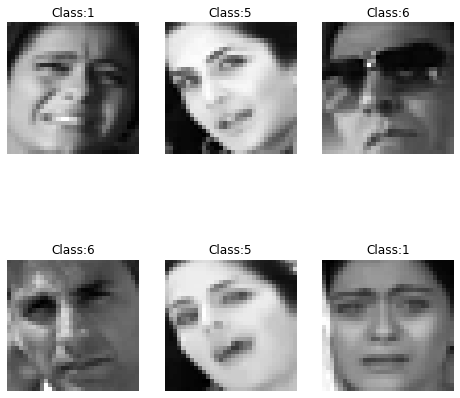

In [7]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

In [8]:
# Varying image shape
dirpath = CFW_data_dir
X_1,y_1 = load_data(dirpath)
N_1,H_1,W_1 = X_1.shape[0:3]
C = 1 if opt['is_grayscale'] else X_1.shape[3]

Dataset shape: (672, 32, 32)


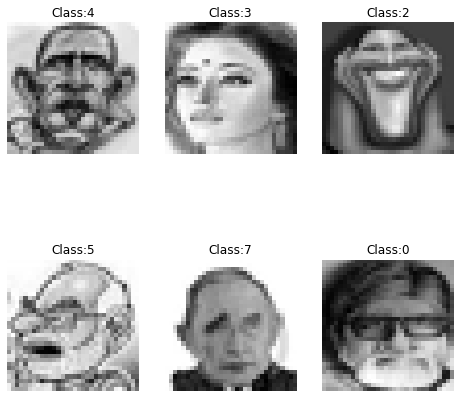

In [9]:
# Show sample images
ind = np.random.randint(0,y_1.shape[0],6)
disply_images(X_1[ind,...],y_1[ind], row=2,col=3)

In [10]:
#Same image shape: 195 X 231
dirpath = yale_data_dir
X_2,y_2 = load_data(dirpath)
N_2,H_2,W_2 = X_2.shape[0:3]
C = 1 if opt['is_grayscale'] else X_2.shape[3]

Dataset shape: (165, 32, 32)


[ 43  75 108  88  27  10]


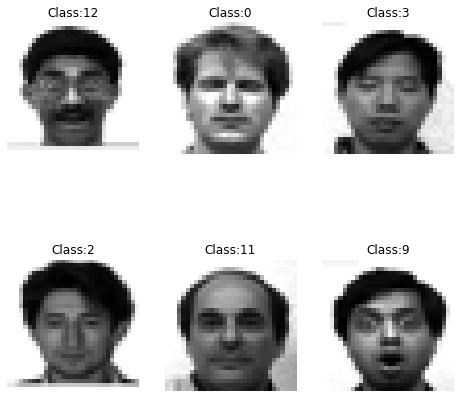

In [11]:

# Show sample images
ind = np.random.randint(0,y_2.shape[0],6)
print(ind)
disply_images(X_2[ind,...],y_2[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features


---


In [12]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

In [13]:
X_1 = X_1.reshape((N_1,H_1*W_1*C))

In [14]:
X_2 = X_2.reshape((N_2,H_2*W_2*C))

In [15]:
print(X.shape)
print(X_1.shape)
print(X_2.shape)

(400, 1024)
(672, 1024)
(165, 1024)


###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [16]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    
    eigenvectors = PCA(n_components=k).fit(X)
    


    return eigenvectors

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [17]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    
    kpca=KernelPCA(n_components=k,kernel=kernel, fit_inverse_transform=True, gamma=10,degree=degree)
    X_k = kpca.fit(X)
    return X_k

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.


Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [18]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    klda = LDA(n_components=k)

    X_k = klda.fit(X,y)
    
    return X_k

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [19]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    kpca_k = get_kernel_pca(X,X.shape[0])
    kpca=KernelPCA(n_components=k,kernel=kernel, fit_inverse_transform=True, gamma=10,degree=degree)
    X_k = kpca.fit(X)

    
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.


In [20]:
def get_vgg_features(dirpath):
    
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 



In [21]:
def get_resnet_features(dirpath):
    
    
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    
    return features

# Questions

1(a). What are eigen faces? 


1(b). How many eigen vectors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples and make a convincing argument.
   

1(c). Reconstruct  the  image  back for each case


In [22]:
def reconstruct_images(eigenvectors,X_k,mean):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    
    
    reconstruct_X=X_k.dot(eigenvectors)+mean
    
    
    
    return reconstruct_X    

In [23]:
def plot_variance_graph_LDA(X,y,variance=97):
    covar_matrix = LDA()

    X_k = covar_matrix.fit(X,y)
    variance_arr =covar_matrix.explained_variance_ratio_
    var=np.array(np.cumsum(np.round(variance_arr, decimals=3)*100))
    k=len(var[var<=variance])
    #print("%d components are needed for %d  variance"%(k,variance))

    #plot for variance explained
    """plt.ylabel("% Variance Explained")
    plt.xlabel("# of Features")
    plt.title("LDA Analysis")
    plt.plot(var)"""
    
    return k


In [24]:
def plot_variance_graph_pca(data,variance=97):
    
    pca_k = PCA().fit(data)
    variance_arr =pca_k.explained_variance_ratio_
    var=np.array(np.cumsum(np.round(variance_arr, decimals=3)*100))
    k=len(var[var<=variance])
    #print("%d components are needed for %d  variance"%(k,variance))

    """plt.figure(figsize=(10, 5))
    plt.xlabel("PCA")
    plt.ylabel("Variance")
    plt.title("PCA Analysis")
    plt.plot(var, lw=3)"""
    
    return k

In [25]:
def split_data_test_train(data,target,shuffle=False,valid_split=opt['val_split']):
    
    #shuffling the data
    stacked= np.column_stack((data,target))
    
    if shuffle == True:
        np.random.shuffle(stacked)
    
    train_cnt=int(valid_split*stacked.shape[0])
    
    train=np.array(stacked[:train_cnt])
    test=np.array(stacked[train_cnt:])
    
    X_train=train[:,:-1]
    y_train=np.array(train[:,-1:],dtype='int')
    
    X_test=test[:,:-1]
    y_test=np.array(test[:,-1:],dtype='int')
    
    #print("train_images: ",X_train.shape," train_labels:",y_train.shape," test_images:",X_test.shape," test_lebels:",y_test.shape)
    return X_train,np.ravel(y_train),X_test,np.ravel(y_test)

In [26]:
def show_eigen_faces(components,k,h,w):
    eigenfaces = components.reshape((k, h, w))
    eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
    disply_images(eigenfaces, eigenface_titles,2,3)


In [27]:
def show_reconstructed_imgs(components,images,target,mean,h,w):

    reconstructed_imgs=reconstruct_images(components,images,mean)
    images1=reconstructed_imgs.reshape((reconstructed_imgs.shape[0],h,w))
    ind=np.unique(target, return_index=True, return_inverse=False, return_counts=False)[1]
    disply_images(images1[ind,...],target[ind], row=2,col=int(len(ind)/2))

In [28]:
def recognition_rate(X_train,y_train,X_test,y_test):

    step = int(X_train.shape[0]/5)
    k_list= [i for i in range(step,X_train.shape[0],step)]
    #print(k_list)
    classes = len(np.unique(y_train))
    labels= ["%d" % i for i in range(classes)]
    fig, axes = plt.subplots(2, 2, figsize=(8, 6), dpi=200)
    for i,k in enumerate(k_list[:4]):
        ax= axes.flatten()[i]
        pca = get_pca(X_train,k)
        variance_arr =pca.explained_variance_ratio_
        var=np.array(np.cumsum(np.round(variance_arr, decimals=3)*100))
        train_k = pca.transform(X_train)
        test_k = pca.transform(X_test)
        recons_train = reconstruct_images(pca.components_,train_k,pca.mean_)
        recons_test= reconstruct_images(pca.components_,test_k,pca.mean_)
        
        correct_label=0
        correct_label_list=np.zeros((classes),dtype='int')
        for idx in range(recons_test.shape[0]):
            
            diff = recons_train - recons_test[idx,:]
            
            norms = np.linalg.norm(diff, axis=1) #Calculating eucledian distance:||A||_F = [sum_{i,j} abs(a_{i,j})^2]^{1/2}
            pred_idx = np.argmin(norms)
            if y_train[pred_idx] == y_test[idx]:
                correct_label+=1
                correct_label_list[y_test[idx]]+=1
        #print(correct_label_list)
        ax.plot(labels, correct_label_list,marker='o', mfc='r')
        ax.set_xlabel("classes")
        ax.set_ylabel("correct preds")
        ax.set_title("recognition rate:%.2f k:%d variance:%.1f"%(correct_label/X_test.shape[0],k,var[k-1]))
        plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    fig.tight_layout()


**IMFDB_EigenFaces**

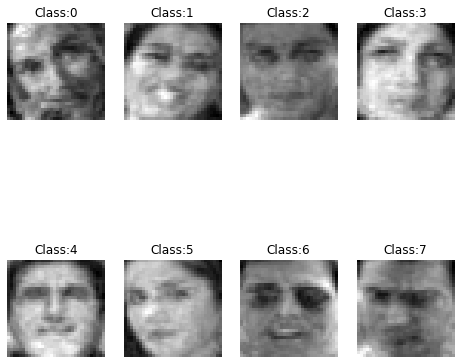

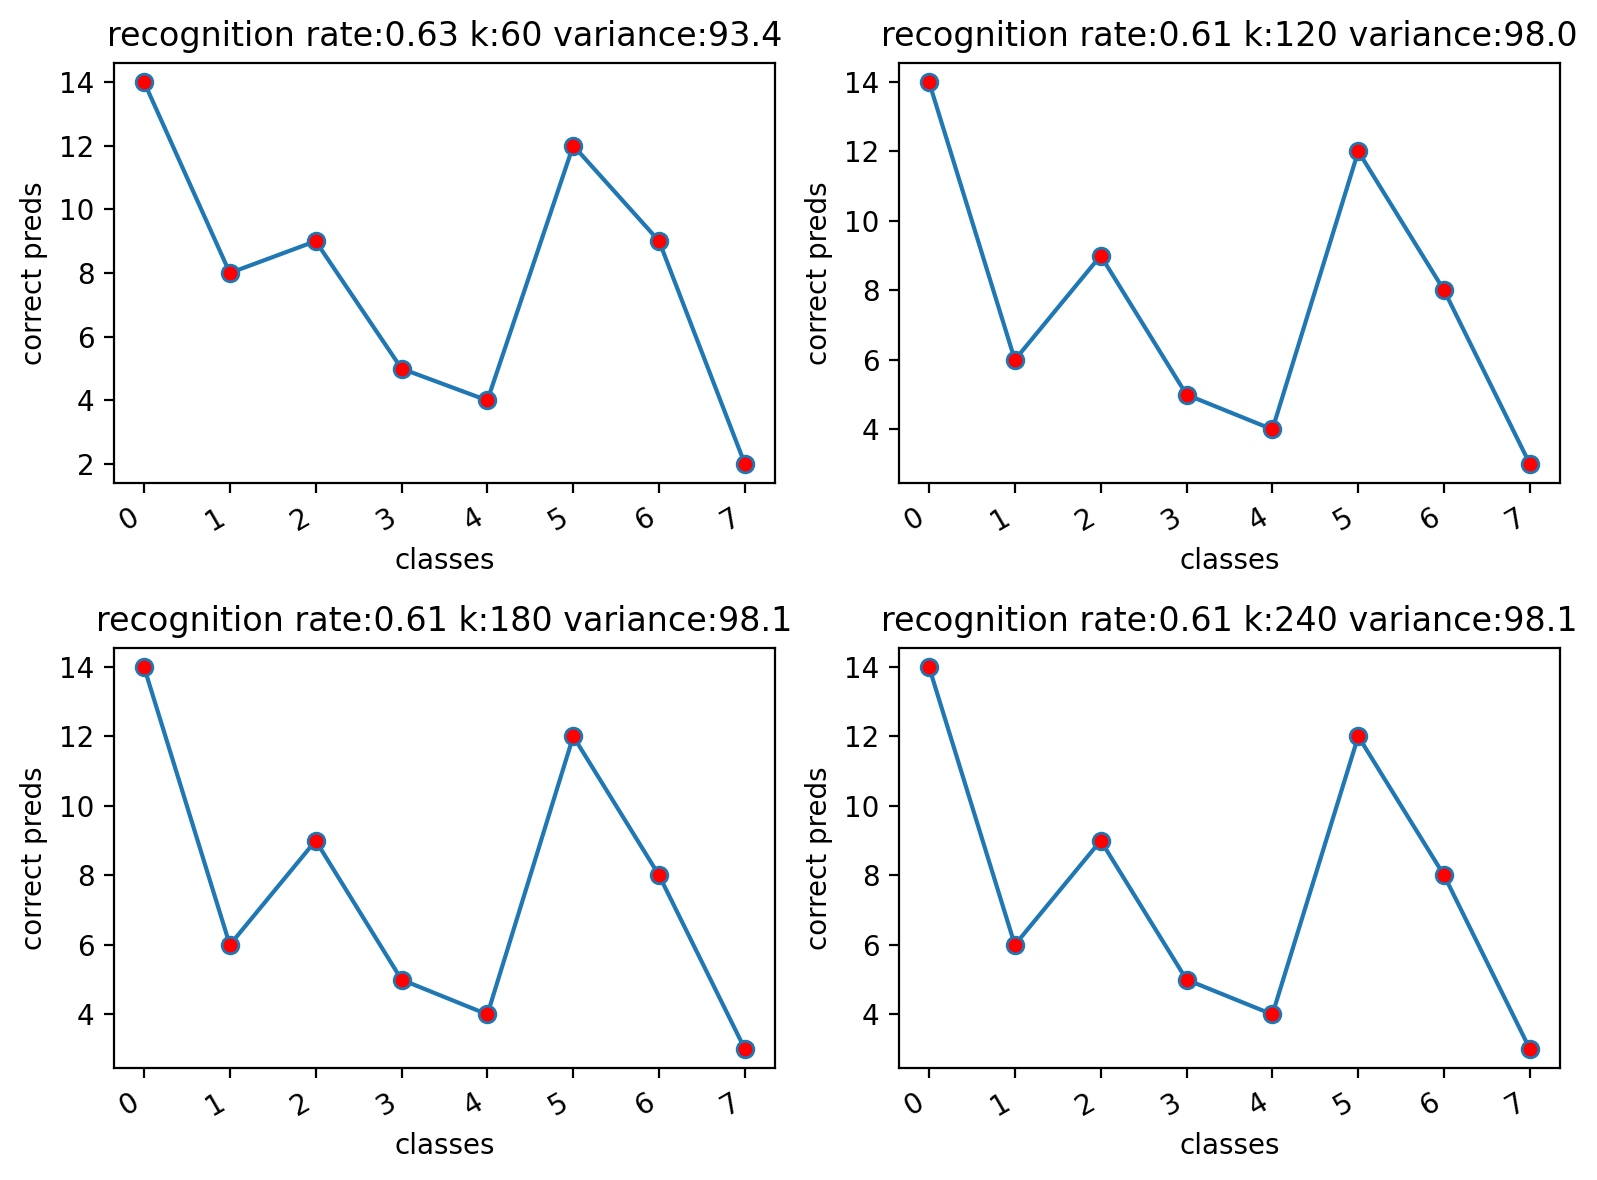

In [29]:
X_train_IMFDB, y_train_IMFDB, X_test_IMFDB, y_test_IMFDB = split_data_test_train(X,y,True)

#show variance graph
#plot_variance_graph_pca(X_train_IMFDB)

#eigen vectors with k components
k1=150
IMFDB_pca = get_pca(X_train_IMFDB,k1)
X_train_k_IMFDB=IMFDB_pca.transform(X_train_IMFDB)
X_test_k_IMFDB=IMFDB_pca.transform(X_test_IMFDB)

#show eigen faces
#1(a)
#show_eigen_faces(IMFDB_pca.components_,k1,H,W)

#showing the reconstruced images of test data (can be changed to train)
# 1(b)
show_reconstructed_imgs(IMFDB_pca.components_,X_test_k_IMFDB,y_test_IMFDB,IMFDB_pca.mean_,H,W)

#face which is difficult to recognize with fewer faces
#THE RECOGNITION RATE CHANGES EVERYTIME BECAUSE THE DATA IS BEING SHUFFLED
# 1(c,d)
recognition_rate(X_train_IMFDB,y_train_IMFDB,X_test_IMFDB,y_test_IMFDB)


**CFW_EigenFaces**

(504, 1024)


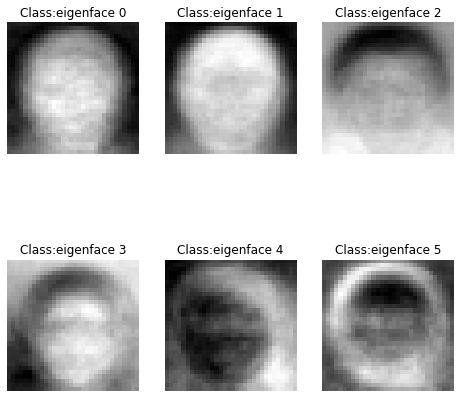

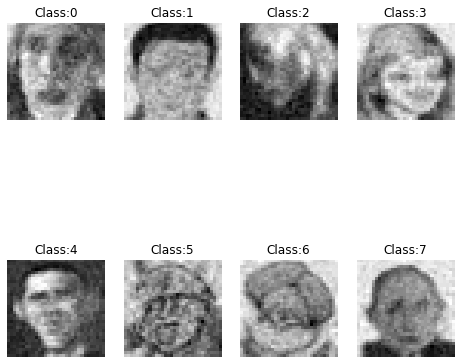

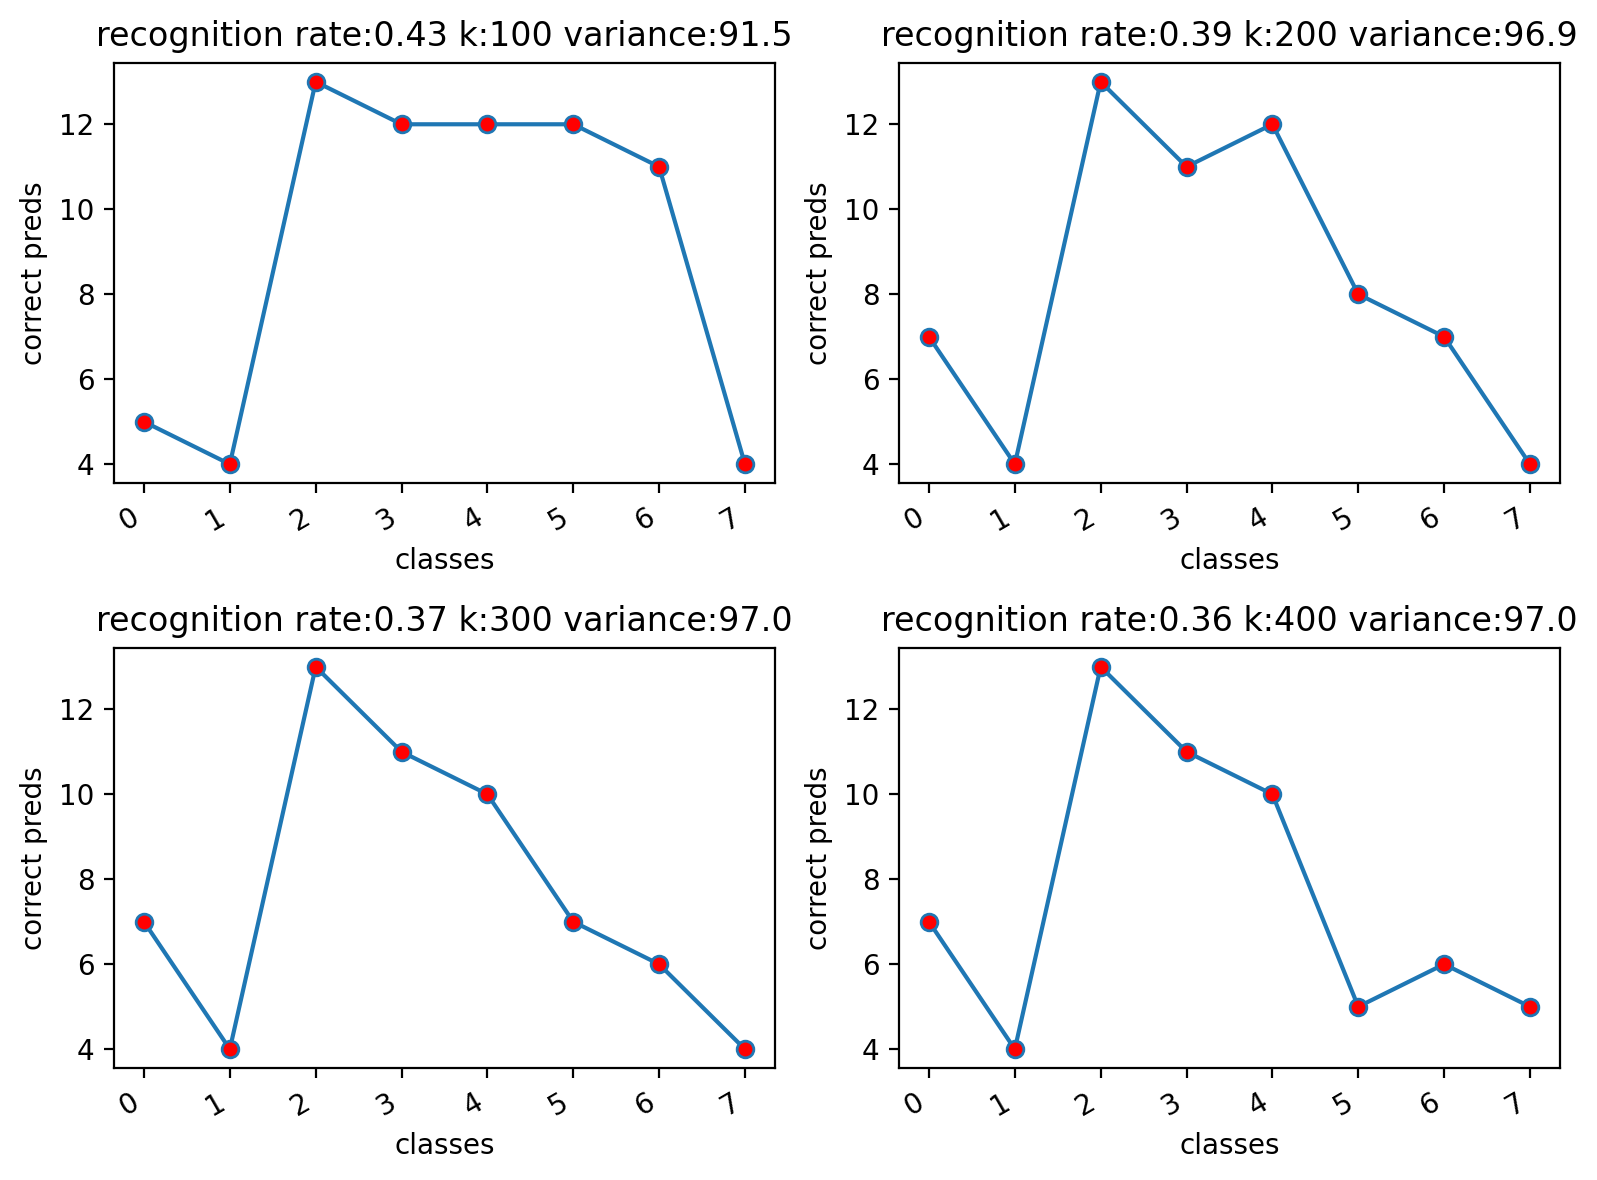

In [30]:
X_train_CFW, y_train_CFW, X_test_CFW, y_test_CFW = split_data_test_train(X_1,y_1,True)

print(X_train_CFW.shape)

#eigen vectors with k components
k2=300
CFW_pca = get_pca(X_train_CFW,k2)
X_train_k_CFW=CFW_pca.transform(X_train_CFW)
X_test_k_CFW=CFW_pca.transform(X_test_CFW)

#show eigen faces
#1(a)
show_eigen_faces(CFW_pca.components_,k2,H,W)

#showing the reconstruced images of test data (can be changed to train)
#1(b)
show_reconstructed_imgs(CFW_pca.components_,X_test_k_CFW,y_test_CFW,CFW_pca.mean_,H,W)

#face which is difficult to recognize with fewer faces
#THE RECOGNITION RATE CHANGES EVERYTIME BECAUSE THE DATA IS BEING SHUFFLED
#1(c,d)
recognition_rate(X_train_CFW,y_train_CFW,X_test_CFW,y_test_CFW)

**Yale_EigenFaces**

(123, 1024)


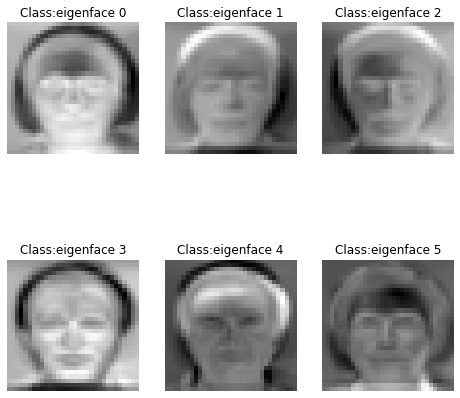

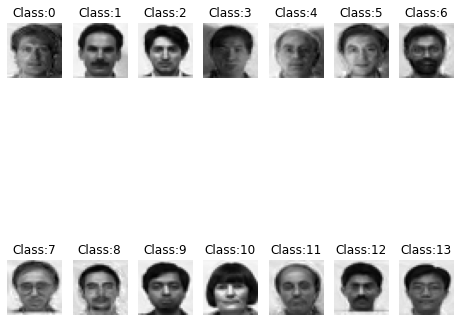

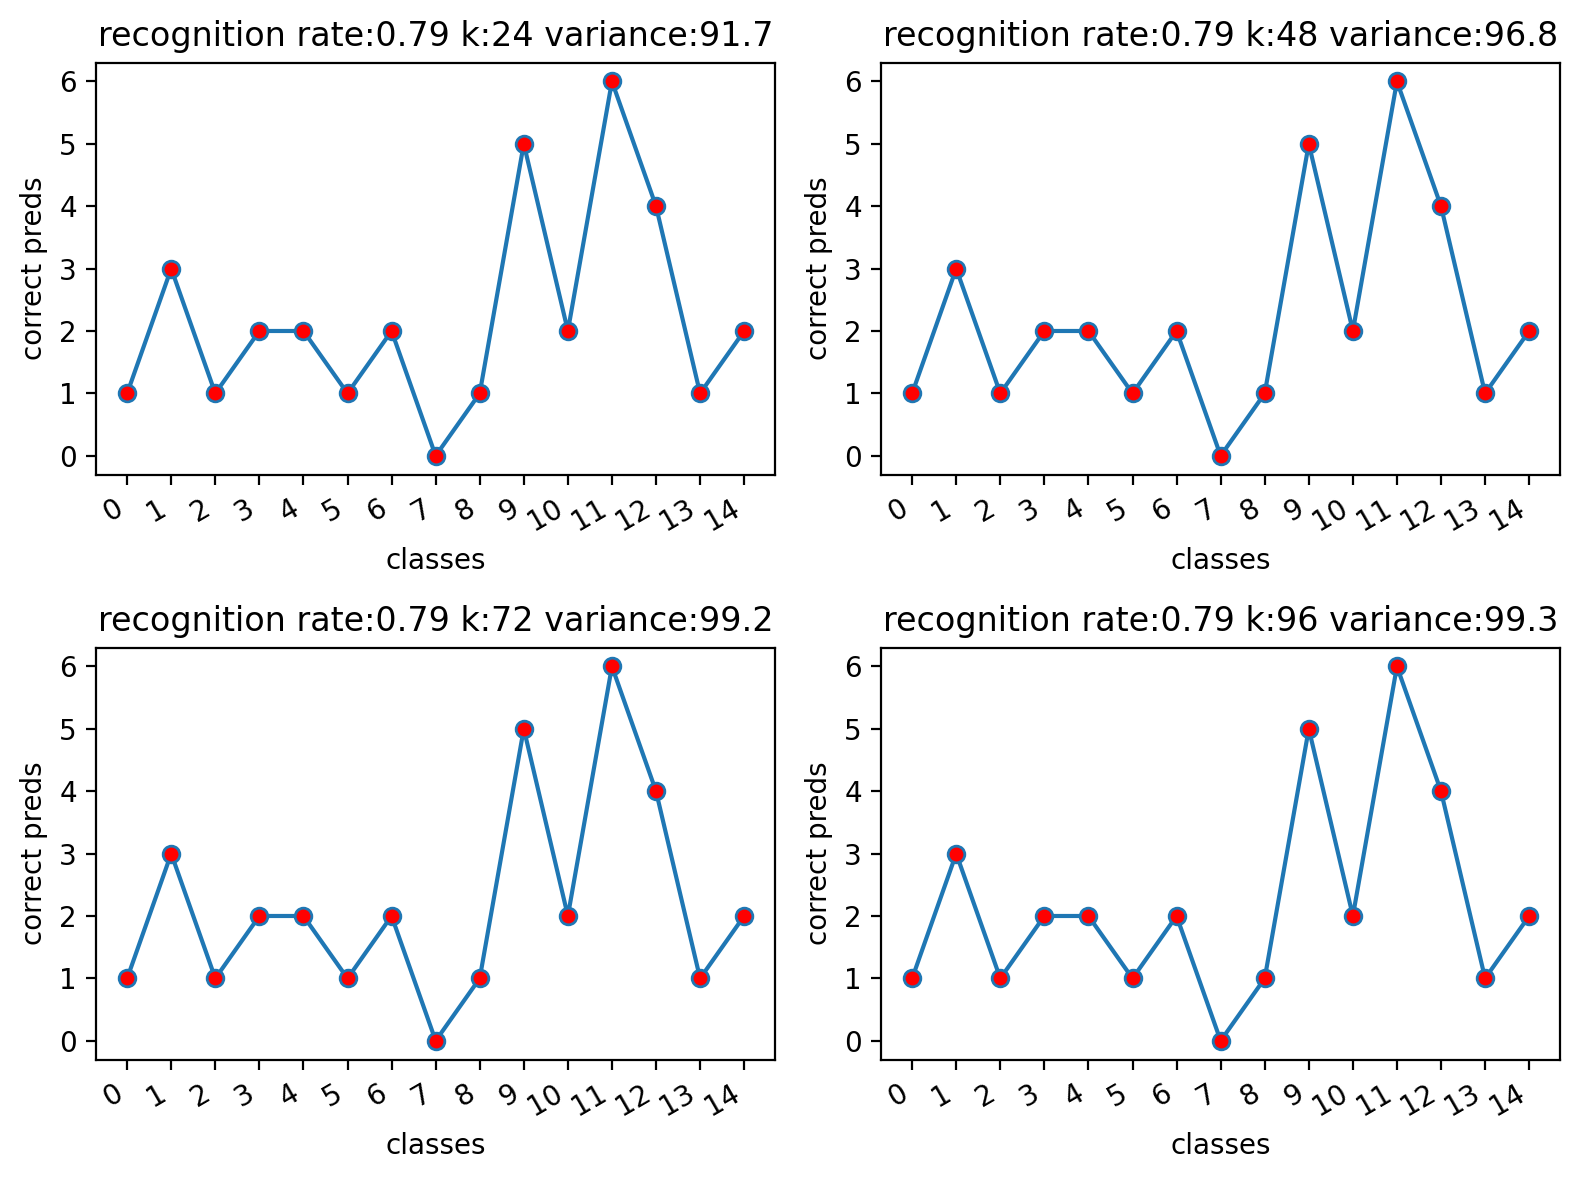

In [31]:
X_train_yale, y_train_yale, X_test_yale, y_test_yale = split_data_test_train(X_2,y_2,True)

print(X_train_yale.shape)
#show variance graph
#plot_variance_graph_pca(X_train_yale)

#eigen vectors with k components
k3=90
yale_pca = get_pca(X_train_yale,k3)
X_train_k_yale=yale_pca.transform(X_train_yale)
X_test_k_yale=yale_pca.transform(X_test_yale)

#show eigen faces
#1(a)
show_eigen_faces(yale_pca.components_,k3,H,W)

#showing the reconstruced images of test data (can be changed to train)
#1(b)
show_reconstructed_imgs(yale_pca.components_,X_test_k_yale,y_test_yale,yale_pca.mean_,H,W)

#face which is difficult to recognize with fewer faces
#THE RECOGNITION RATE CHANGES EVERYTIME BECAUSE THE DATA IS BEING SHUFFLED
#1(c,d)
recognition_rate(X_train_yale,y_train_yale,X_test_yale,y_test_yale)

1(d). Which person/identity is difficult to represent compactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers
 

2(a) Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. Write code from scratch making Classifer as a class and functions of training, validation and confusion matrix etc.

2(b) Which method works well? Do a comparitive study. 




> **Logistic Regression**

In [32]:
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,f1_score
import itertools

import numpy as np
from glob import glob
import random
from tqdm import tqdm,trange

In [33]:
class multinomial_regression:
    def __init__(self,shape,n_class):
        self.weight=np.zeros((n_class,shape[1]))
        self.bias=np.zeros((n_class,1))
        self.classes= n_class


    def linearPredict(self,featureMat):
        """It calculates the logit scores for each possible outcome.

        Args-
        featureMat- A numpy array of features

        Returns-
        logitScores- Logit scores for each possible outcome of the target variable for each feature set in the feature matrix
        """
        
        logitScores = (self.weight.dot(featureMat.T) +self.bias).T
        

        return logitScores

    def softmaxNormalizer(self,logitMatrix):
        
        """Converts logit scores for each possible outcome to probability values.
    
        Args-
            logitMatrix - This is the output of our logitPredict function; consists  logit scores for each feature set

        Returns-
            probabilities - Probability value of each outcome for each feature set
        """
        
        exponent_matrix=np.exp(logitMatrix)
        
        exponent_MatSum=np.array(np.sum(exponent_matrix,axis=1).reshape(logitMatrix.shape[0],1))
        
        probabilities=exponent_matrix/exponent_MatSum
        

        
        return probabilities
    
    def multinomialLogReg(self,features):
        """Performs logistic regression on a given feature set.

        Args- 
            features- Numpy array of features(standardized)

        Returns-
            probabilities, predictions
            Here,
                probabilities: Probability values for each possible outcome for each feature set in the feature matrix
                predictions: Outcome with max probability for each feature set
        """
        
        logitScores = self.linearPredict(features)
        probabilities = self.softmaxNormalizer(logitScores)
        predictions = np.argmax(probabilities,axis=1)  #returns the outcome with max probability
        
        
        return probabilities, predictions
    
    def crossEntropyLoss(self,probabilities, target):
        
        """Calculates cross entropy loss for a set of predictions and actual targets.

        Args-
            predictions- Probability predictions, as returned by multinomialLogReg function
            target- Actual target values
        Returns- 
            CELoss- Average cross entropy loss
        
        formula - H(y,p)=−∑y(i)log(p(i))   y=1 for target values else 0 , p=softmax probablity matrix
        """
        n_samples = probabilities.shape[0]
        CELoss = 0
        
        for i in  range(n_samples):
            #print(probabilities.shape,target.shape)
            #print(i,target[i])
            CELoss += -np.log(probabilities[i,target[i]])     
            
        CELoss /= n_samples
        return CELoss   

    def mbgd(self,learning_rate, epochs,batch_size, target, features):
        """Performs mini batch gradient descent descent optimization on the model.

        Args-
            learning_rate- Size of the step the function will take during optimization
            epochs- No. of iterations the function will run for on the model
            batch_size - No. of data sample taken for each batch
            target- Numpy array containing actual target values
            features- Numpy array of independent variables

        Returns-
            weights, biases, loss_list
            where,
                weights- Latest weight calculated (Numpy array)
                bias- Latest bias calculated (Numpy array)
                loss_list- Array containing list of losses observed after each epoch    
        """
        
        loss_list = np.array([]) #initiating an empty array
        

        for i in range(epochs):
            for idx in range(batch_size,features.shape[0],batch_size):
                #Getting data batch_wise
                start_idx=idx-batch_size
                if features.shape[0]-idx<batch_size:
                    idx=features.shape[0]
                    
                probabilities, _ = self.multinomialLogReg(features[start_idx:idx,:]) # Calculates probabilities for each possible outcome
                CELoss = self.crossEntropyLoss(probabilities, target[start_idx:idx]) # Calculates cross entropy loss for actual target and predictions
                if idx == features.shape[0]:
                    loss_list = np.append(loss_list, CELoss) # Adds the CELoss value for the epoch to loss_list


                probabilities[np.arange(features[start_idx:idx,:].shape[0]),target[start_idx:idx]] -= 1 # Substract 1 from the scores of the correct outcome

                grad_weight = probabilities.T.dot(features[start_idx:idx]) # gradient of loss w.r.t. weights
                grad_biases = np.sum(probabilities, axis = 0).reshape(-1,1) # gradient of loss w.r.t. biases

                #updating weights and biases
                self.weight -= (learning_rate * grad_weight)
                self.bias -= (learning_rate * grad_biases)
            
        return self.weight, self.bias, loss_list

    
    def accuracy(self,predictions, target):
        """Calculates total accuracy for our model.

        Args- 
            predictions- Predicted target outcomes as predicted by our MLR function
            target- Actual target values

        Returns-
            accuracy- Accuracy percentage of our model
        """
        correctPred = 0
        for i in range(len(predictions)):
            if predictions[i] == target[i]:
                correctPred += 1
        accuracy = (correctPred/len(predictions))
        
        return accuracy

In [34]:
def accuracy(preds,label):
    correctPreds=0
    for i in range(len(preds)):
        if preds[i] == label[i]:
            correctPreds += 1
    acc = correctPreds / len(preds) 
    return acc

In [35]:
def show_confusion_table(y_true, y_pred, labels, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('MNIST')
    #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(int(cm[i, j]), fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()



In [36]:
def Logistic_regression(X_train,y_train,X_test,y_test,epochs,learning_rate=0.001,batch_size=32):
    
    """MLR = LogisticRegression(penalty='l2', multi_class='multinomial', solver='newton-cg',max_iter=epochs).fit(X_train,y_train)

    y_pred = MLR.predict(X_test)

    acc=accuracy(y_pred,y_test)
    print("sklearn",acc)"""
    
    
    classes= len(np.unique(y_train))
    MLR1= multinomial_regression(X_train.shape,classes)

    updatedWeights, updatedBiases, loss_list = MLR1.mbgd(learning_rate,epochs,batch_size,y_train, X_train)
    
    testProbabilities, testPredictions = MLR1.multinomialLogReg(X_test)

    acc=MLR1.accuracy(testPredictions,y_test)
    f1 =  f1_score(testPredictions,y_test,average="micro")
    return acc,f1

**SVM**

In [37]:
from sklearn import datasets, svm

In [38]:
def svm_classification(train_X,train_y,test_X,test_y,gamma=0.1,kernel='rbf'):
    
    classes=len(np.unique(train_y))

    
    # Create a classifier: a support vector classifier
    classifier = svm.SVC(gamma=gamma,decision_function_shape='ovo',kernel=kernel)
    #fit to the trainin data
    classifier.fit(train_X,train_y)
    
    y_pred = classifier.predict(test_X)
    
    acc= accuracy(y_pred,test_y)
    f1 =  f1_score(y_pred,test_y,average="micro")
   
    
    return acc,f1


**Decision tress**

In [39]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
import math

In [40]:
def decision_tree(train_X,train_y,test_X,test_y):
    clf = DecisionTreeClassifier()
    clf = DecisionTreeClassifier(criterion = "gini",  max_depth = 3,  min_samples_split = 5,min_samples_leaf = 2, max_features = int(math.sqrt(train_X.shape[1])))
    # Train Decision Tree Classifier
    clf = clf.fit(train_X,train_y)

    #Predict the response for test dataset
    y_pred = clf.predict(test_X)

    acc=accuracy(y_pred,test_y)
    f1 =  f1_score(y_pred,test_y,average="micro")
    
    return acc,f1

**MLP**

In [41]:
from sklearn.neural_network import MLPClassifier

In [42]:
def MLP(train_X,train_y,test_X,test_y):
    clf = MLPClassifier(hidden_layer_sizes=(1024,), batch_size=32,learning_rate='adaptive',max_iter=1000, verbose=False, early_stopping=False).fit(train_X, np.ravel(train_y))
    y_pred = clf.predict(test_X)
    acc=accuracy(y_pred,test_y)
    f1 =  f1_score(y_pred,test_y,average="micro")
    #print("%.3f %.3f"%(acc*100,f1))
    
    return acc,f1

3.Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? 

**T-SNE**

In [43]:
import seaborn as sns
import matplotlib.patheffects as PathEffects

In [44]:
def plot_tsne(tsne_result,labels,title):
    # Plot the result of our TSNE with the label color coded
    # A lot of the stuff here is about making the plot look pretty and not TSNE
    tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': labels})
    fig, ax = plt.subplots(1)
    sns.scatterplot(x='tsne_1', y='tsne_2',legend="full", hue='label',palette="deep",data=tsne_result_df, ax=ax,s=120)
    lim = (tsne_result.min()-5, tsne_result.max()+5)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [45]:
def tsne_fn(X,y,title):
    tsne = TSNE(n_components=2,perplexity= 40)
    tsne_result= tsne.fit_transform(X)
    
    plot_tsne(tsne_result,y,title)

**KNN**

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

4(c)Show empirical results  with  all  the  representations

In [46]:
from sklearn.neighbors import KNeighborsClassifier


In [47]:
def best_k_knn(X_train,y_train,X_test,y_test):
    print("Using SKLEARN")
    lix = []
    liy = []
    index=0
    acc=0
    for k in range(2, 100):
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(X_train, y_train)
        liy.append(neigh.score(X_test, y_test))
        if liy[k-2]>acc:
            acc=liy[k-2]
            index=k-2
        lix.append(k)

    plt.plot(lix, liy)
    plt.show()
    print("max acc at k="+str(index+1)+" acc of "+str(acc))

In [48]:
def knn(X_train,y_train,X_test,y_test,k):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    print("Test Accuracy: %.3f"%(neigh.score(X_test, y_test)))

**CLASSIFICSTION PIPELINE**

In [49]:
from tqdm import tqdm

In [50]:
def get_features(method,directory, X_train,y_train, X_test, y_test, variance):
    
    if method == "PCA":
            k= plot_variance_graph_pca(X_train,variance)
            pca_k = get_pca(X_train,k)
            X_train_k = pca_k.transform (X_train)
            X_test_k = pca_k.transform (X_test)
            
    elif method == "kPCA":
        k= plot_variance_graph_pca(X_train,variance)
        kpca_k = get_kernel_pca(X_train, k)
        X_train_k = kpca_k.transform (X_train)
        X_test_k = kpca_k.transform (X_test)

    elif method == "LDA": 
        k= plot_variance_graph_LDA (X_train,y_train,variance)
        lda_k = get_lda(X_train,y_train, k)
        X_train_k = lda_k.transform (X_train)
        X_test_k = lda_k.transform (X_test)
        
    elif method == "kLDA":
        k= plot_variance_graph_LDA (X_train,y_train,variance)
        lda_k= get_kernel_lda(X_train,y_train,k)
        X_train_k = lda_k.transform (X_train)
        X_test_k = lda_k.transform (X_test)
        
    elif method == "PCA+LDA":
        k= plot_variance_graph_pca(X_train,variance)
        kpca_k = get_kernel_pca(X_train, k)
        X_train_k = kpca_k.transform (X_train)
        X_test_k = kpca_k.transform (X_test) 
        k= plot_variance_graph_LDA (X_train_k,y_train,variance)
        lda_k = get_lda(X_train_k,y_train, k)
        X_train_k = lda_k.transform (X_train_k)
        X_test_k = lda_k.transform (X_test_k)
        
            
    return X_train_k,X_test_k
    

In [51]:
def classifier_pipeline(images, labels, data_name,feature_extraction_method, classifier_methods,variance = 97,directory= None,epoch=1200):
    
    X_train, y_train, X_test, y_test = split_data_test_train(images,labels,True)
    #print(feature_extraction_method,classifier_methods)
    
    acc_array = np.zeros((len(feature_extraction_method),len(classifier_methods)))
    f1_array = np.zeros((len(feature_extraction_method),len(classifier_methods)))
    #print(acc_array.shape)
    
    for method,i in tqdm(zip(feature_extraction_method,range(len(feature_extraction_method)))):
        
        if method == "VGG":
            features = get_vgg_features(directory)
            train_features, y_train, test_features, y_test = split_data_test_train(features,labels,True)
            #print(np.unique(y_train))

        elif method == "RESNET":
            features = get_resnet_features(directory)
            train_features, y_train, test_features, y_test = split_data_test_train(features,labels,True)

        else:
            train_features, test_features = get_features (method,directory,X_train, y_train, X_test, y_test,variance)
        
        
        
        for classification,j in zip(classifier_methods,range(len(classifier_methods))):
            
            acc=None
            f1= None
            if classification == "logistic":
                acc,f1=Logistic_regression(train_features,y_train,test_features,y_test,epoch)  #IMFDB
                
            elif classification == "SVM":
                acc,f1=svm_classification(train_features,y_train,test_features,y_test)
                
            elif classification == "MLP":
                acc,f1=MLP(train_features,y_train,test_features,y_test)
                
            elif classification == "decision_tree":
                acc,f1=decision_tree(train_features,y_train,test_features,y_test)
            acc_array[i][j] = np.round(acc,decimals=2)
            f1_array[i][j] = np.round(f1,decimals=2)
           
    table_formation(f1_array,feature_extraction_method, classifier_methods,data_name)

In [52]:
def table_formation(cell_data,row_labels,col_labels,data_name):
    fig, ax = plt.subplots() 
    ax.set_axis_off() 
    table = ax.table( 
        cellText = cell_data,  
        rowLabels = row_labels,  
        colLabels = col_labels, 
        rowColours =["palegreen"] * 10,  
        colColours =["palegreen"] * 10, 
        cellLoc ='center',  
        loc ='upper left')         

    ax.set_title('F1 score for %s data'%(data_name), 
                 fontweight ="bold") 

    plt.show() 

In [53]:
#"PCA", "kPCA", "LDA", "kLDA", "PCA+LDA",
feature_extraction_list =["PCA", "kPCA", "LDA", "kLDA", "PCA+LDA","VGG","RESNET" ]
classifiers_list = ["logistic", "SVM", "MLP", "decision_tree"]

7it [03:02, 26.05s/it]


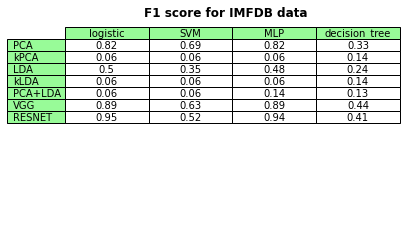

In [54]:
#2(a)
classifier_pipeline(X, y,"IMFDB" , feature_extraction_list,classifiers_list,95, IMFDB_data_dir, epoch = 1200)

7it [09:22, 80.38s/it] 


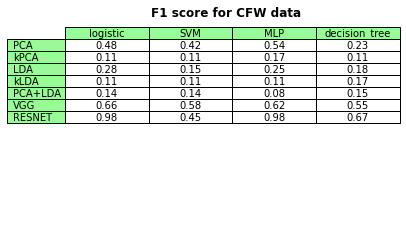

In [55]:
#2(a)
classifier_pipeline(X_1, y_1,"CFW" , feature_extraction_list,classifiers_list,95, CFW_data_dir, epoch = 1200)

3it [00:08,  2.61s/it]/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
7it [02:38, 22.67s/it]


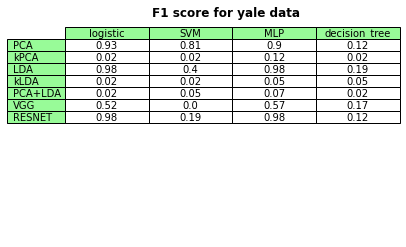

In [56]:
#2(a)
classifier_pipeline(X_2, y_2,"yale" , feature_extraction_list,classifiers_list,95, yale_data_dir, epoch = 600)

In [57]:
def tsne_visualization(images,labels,feature_extraction_method,directory,variance):
    X_train, y_train, X_test, y_test = split_data_test_train(images,labels,True)
    
    
    
    for method,i in zip(feature_extraction_method,range(len(feature_extraction_method))):
        

        if method == "t-sne":
            train_features = X_train
            tsne_fn(train_features,y_train,method) 
            
        else:
            train_features, test_features = get_features (method,directory,X_train, y_train, X_test, y_test,variance)
            plot_tsne(train_features,y_train,method)
            
        


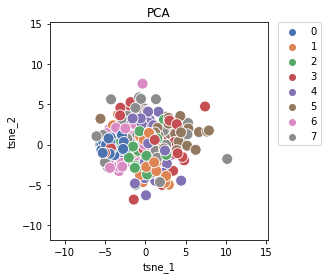

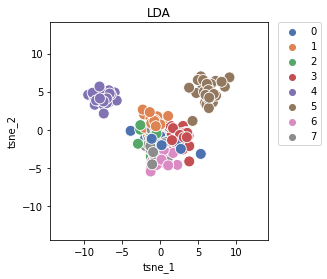

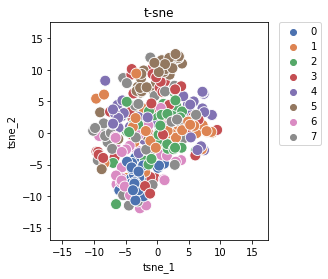

In [58]:
#3
feature_extraction_list =["PCA", "LDA","t-sne" ]
tsne_visualization(X,y,feature_extraction_list,yale_data_dir,95)

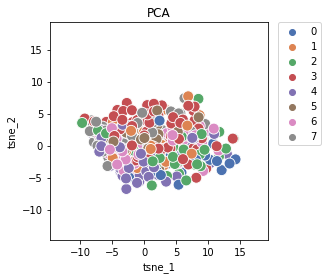

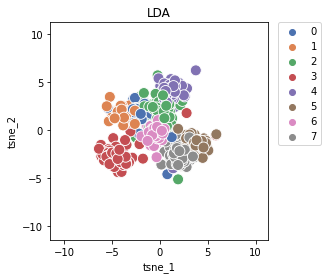

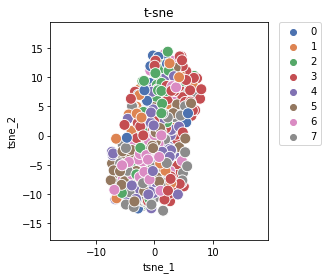

In [59]:
#3
feature_extraction_list =["PCA", "LDA","t-sne" ]
tsne_visualization(X_1,y_1,feature_extraction_list,yale_data_dir,95)

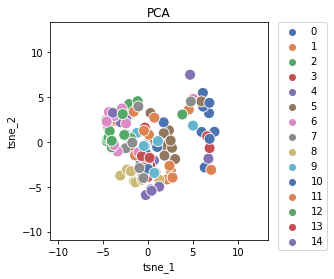

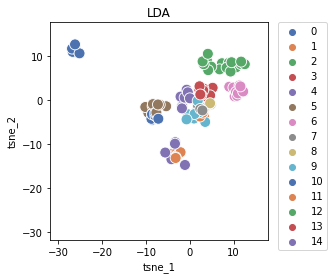

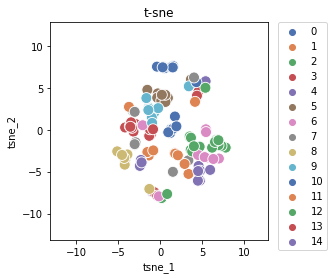

In [60]:
#3
feature_extraction_list =["PCA", "LDA","t-sne" ]
tsne_visualization(X_2,y_2,feature_extraction_list,yale_data_dir,95)

Using SKLEARN


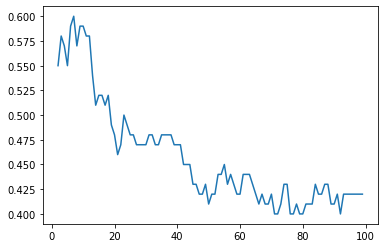

max acc at k=6 acc of 0.6


In [61]:
best_k_knn(X_train_IMFDB,y_train_IMFDB,X_test_IMFDB,y_test_IMFDB)

In [62]:
#4
knn(X_train_k_IMFDB,y_train_IMFDB,X_test_k_IMFDB,y_test_IMFDB,10)

Test Accuracy: 0.600


Using SKLEARN


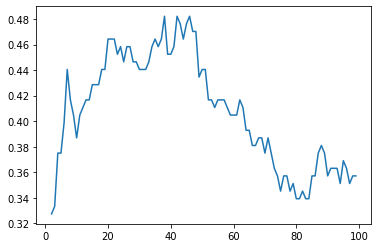

max acc at k=37 acc of 0.48214285714285715


In [63]:
best_k_knn(X_train_CFW,y_train_CFW,X_test_CFW,y_test_CFW)

In [64]:
#4
knn(X_train_CFW,y_train_CFW,X_test_CFW,y_test_CFW,22)

Test Accuracy: 0.464


Using SKLEARN


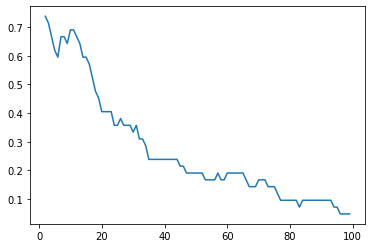

max acc at k=1 acc of 0.7380952380952381


In [67]:
best_k_knn(X_train_yale,y_train_yale,X_test_yale,y_test_yale)

In [66]:
#4
knn(X_train_yale,y_train_yale,X_test_yale,y_test_yale,22)

Test Accuracy: 0.405
